# Data Fusion Group 4 Jupyter Notebook

### Installing necessary libraries

In [ ]:
### Uncomment if library imbalanced-learn is not installed (imbalanced learn performs oversampling when classes are imbalanced)

#pip install imbalanced-learn

### Importing the necessary libraries

In [1]:
import pandas as pd
import csv
import os
from plantcv import plantcv as pcv
import time
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA, KernelPCA
from imblearn.over_sampling import RandomOverSampler
import h5py

In [2]:
print(pcv.__version__)
#print(pcv.__file__)

3.14.2


In [4]:
%matplotlib inline

In [5]:
# Enter path to the data_fusion_guest_lecture file
image_folder_path = ""

# Loads labels
df = pd.read_csv(os.path.join(image_folder_path, "seedling_labels.csv"))

# Creates path to top & side view
df["color_cam_path"] = image_folder_path  + df["color_cam_path"]
df["side_cam_path"] = image_folder_path  + df["side_cam_path"]

# Gives average expert label as a starting point
df["average_expert"] = (df["Expert 1"] + df["Expert 2"]  + df["Expert 3"] + df["Expert 4"]) / 4
df.head()

,Expert 1,Expert 2,Expert 3,Expert 4,color_cam_path,side_cam_path,Rfid,Pos,average_expert
0,4,4,4,4,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1,Plant 0000,4.0
1,1,1,1,1,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1,Plant 0001,1.0
2,1,1,1,1,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1,Plant 0002,1.0
3,4,4,3,3,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1,Plant 0003,3.5
4,3,1,1,1,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1,Plant 0004,1.5


In [6]:
df.describe()

,Expert 1,Expert 2,Expert 3,Expert 4,average_expert
count,994.000000,994.000000,994.000000,994.000000,994.000000
mean,1.831992,1.751509,1.817907,1.845070,1.811620
std,1.055815,1.076913,1.046762,1.068708,1.025991
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.250000
75%,3.000000,3.000000,3.000000,3.000000,3.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000


## Cohen's kappa measure for inter-judge agreement on the original 4 classes

In [7]:
print(cohen_kappa_score(df['Expert 1'], df['Expert 2']))

print(cohen_kappa_score(df['Expert 1'], df['Expert 3']))

print(cohen_kappa_score(df['Expert 1'], df['Expert 4']))

print(cohen_kappa_score(df['Expert 2'], df['Expert 3']))

print(cohen_kappa_score(df['Expert 2'], df['Expert 4']))

print(cohen_kappa_score(df['Expert 3'], df['Expert 4']))





0.7479850775872328
0.7514264091342832
0.789424903841698
0.7636369001230606
0.7976078889813343
0.7981732606365627


In [8]:
class options:
    def __init__(self):
        self.image = df['color_cam_path'][1]
        self.background = df['side_cam_path'][1]
        self.debug = None
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug



In [9]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

In [10]:
img, path, filename = pcv.readimage(filename=args.background)

In [11]:
width = img.shape[0]
height = img.shape[1]

In [12]:
df_copy = df.copy()

In [13]:
### Setting the correct classes for every expert


### normal
df_copy.loc[df_copy['Expert 1']<3, 'Expert 1'] = 1 
df_copy.loc[df_copy['Expert 2']<3, 'Expert 2'] = 1
df_copy.loc[df_copy['Expert 3']<3, 'Expert 3'] = 1
df_copy.loc[df_copy['Expert 4']<3, 'Expert 4'] = 1


### abnormal
df_copy.loc[df_copy['Expert 1']>=3, 'Expert 1'] = 0
df_copy.loc[df_copy['Expert 2']>=3, 'Expert 2'] = 0
df_copy.loc[df_copy['Expert 3']>=3, 'Expert 3'] = 0
df_copy.loc[df_copy['Expert 4']>=3, 'Expert 4'] = 0


## Investigating class imbalance  

In [14]:
print(df_copy['Expert 1'].sum() / df_copy['Expert 1'].count())
print(df_copy['Expert 2'].sum() / df_copy['Expert 2'].count())
print(df_copy['Expert 3'].sum() / df_copy['Expert 3'].count())
print(df_copy['Expert 4'].sum() / df_copy['Expert 4'].count())

0.7062374245472837
0.7112676056338029
0.7082494969818913
0.676056338028169


### So almost 70% of instances are class 1, and the other 30% are class 0

## Cohen's kappa measure for inter-judge agreement on the 2 classes

In [15]:
print(cohen_kappa_score(df_copy['Expert 1'], df_copy['Expert 2']))

print(cohen_kappa_score(df_copy['Expert 1'], df_copy['Expert 3']))

print(cohen_kappa_score(df_copy['Expert 1'], df_copy['Expert 4']))

print(cohen_kappa_score(df_copy['Expert 2'], df_copy['Expert 3']))

print(cohen_kappa_score(df_copy['Expert 2'], df_copy['Expert 4']))

print(cohen_kappa_score(df_copy['Expert 3'], df_copy['Expert 4']))


0.8513573806500326
0.839657043417052
0.8446389496717724
0.8852357533445678
0.8841761827079935
0.8632438894792773


# Building the dataset: reading every image (both its color and its grayscale counterpart) and setting them in a pandas dataframe, along with all their features

In [16]:
### Building the dataset

start = time.time()


img_list = []
resize_img_list = []
s_thresh_list = []
b_thresh_list = []
bs_list = []
xor_img_list = []
closed_ab_list = []
analysis_list = []

### resizing images for faster iterations, since using original size is slow and does not actually achieve better accuracy on final models

new_width = width//3 ### floor division
new_height = height//3 ### floor division

for i in range(df_copy.shape[0]):
    
    ### Following the Plantcv tutorial for VIS images, all parameters were tested for optimal values via trial and error
    
    img, path, filename = pcv.readimage(df_copy['color_cam_path'][i])
    resize_img = pcv.transform.resize(img=img, size=(new_height, new_width), interpolation="auto")
    s = pcv.rgb2gray_hsv(rgb_img=resize_img, channel='s')
    s_thresh = pcv.threshold.binary(gray_img=s, threshold=140, max_value=255, object_type='light')
    s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
    gaussian_img = pcv.gaussian_blur(img=s_thresh, ksize=(5, 5), sigma_x=0, sigma_y=None)
    b = pcv.rgb2gray_lab(rgb_img=resize_img, channel='b')
    b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, 
                                object_type='light')
    bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_thresh)
    masked = pcv.apply_mask(img=resize_img, mask=bs, mask_color='white')
    masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
    masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
    maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                      max_value=255, object_type='dark')
    maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                       max_value=255, object_type='light')
    maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                      max_value=255, object_type='light')
    ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
    ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
    opened_ab = pcv.opening(gray_img=ab)
    xor_img = pcv.logical_xor(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
    ab_fill = pcv.fill(bin_img=ab, size=200)
    closed_ab = pcv.closing(gray_img=ab_fill)
    masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')
    id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)
    roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=200, w=200)
    roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=resize_img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')
    obj, mask = pcv.object_composition(img=resize_img, contours=roi_objects, hierarchy=hierarchy3) ### slower command than all the others
    analysis_image_test = pcv.analyze_object(img=resize_img, obj=obj, mask=mask, label="default")
    
    #img_list.append(img)
    resize_img_list.append(resize_img.flatten())
    s_thresh_list.append(s_thresh.flatten())
    b_thresh_list.append(b_thresh.flatten())
    bs_list.append(bs.flatten())
    xor_img_list.append(xor_img.flatten())
    closed_ab_list.append(closed_ab.flatten())
    analysis_list.append(analysis_image_test.flatten())
    
end = time.time()

print(f"The time to run this cell in seconds is: {end - start}") ### typically for these features it takes around 160 seconds

C:\Users\Uni\anaconda3\lib\site-packages\plantcv\plantcv\closing.py:26: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.


The time to run this cell in seconds is: 164.52493047714233


In [17]:
# plt.imshow(analysis_image_test_pca, cmap='gray')
# plt.show()

In [18]:
df_copy['Resize Image'] = resize_img_list
df_copy['Analysis Image'] = analysis_list
df_copy['s_thresh'] = s_thresh_list
df_copy['b_thresh'] = b_thresh_list
df_copy['bs'] = bs_list
df_copy['xor_img'] = xor_img_list
df_copy['closed_ab'] = closed_ab_list


df_copy.head()

,Expert 1,Expert 2,Expert 3,Expert 4,color_cam_path,side_cam_path,Rfid,Pos,average_expert,Resize Image,Analysis Image,s_thresh,b_thresh,bs,xor_img,closed_ab
0,0,0,0,0,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1,Plant 0000,4.0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1,1,1,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1,Plant 0001,1.0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,1,1,1,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1,Plant 0002,1.0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,0,0,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1,Plant 0003,3.5,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,1,1,1,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1,Plant 0004,1.5,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


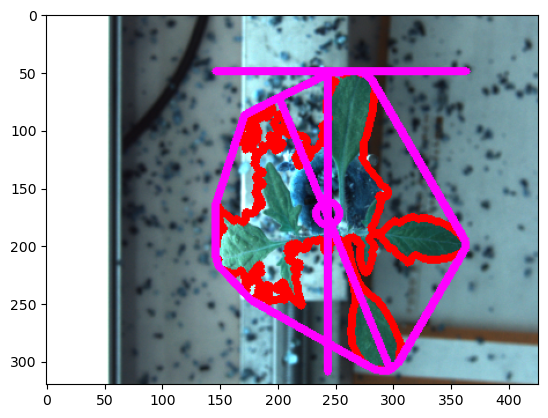

In [19]:
### Printing a test image from the dataframe to ensure that the images are saved correctly

test = df_copy['Analysis Image'][100]
plt.imshow(test.reshape((new_width, new_height,3)), cmap='gray')
plt.show()

In [20]:
type(df_copy["Analysis Image"][0])

numpy.ndarray

In [21]:
df_copy["Analysis Image"][0].shape

(408960,)

In [22]:
# s_thresh_list_test_pca = []
# b_thresh_list_test_pca = []
# bs_list_test_pca = []
# xor_img_list_test_pca = []
# closed_ab_list_test_pca = []

# analysis_list_test_pca = []

In [23]:
### Transforming the lists into numpy arrays for classification later

start = time.time()


resize_img_array = resize_img_list[0]
analysis_image_array = analysis_list[0]
s_thresh_image_array = s_thresh_list[0]
b_thresh_image_array = b_thresh_list[0]
bs_image_array = bs_list[0]
xor_img_image_array = xor_img_list[0]
closed_ab_image_array = closed_ab_list[0]



for k in range(1,df_copy.shape[0]):
    
    intermediate_resize_image = resize_img_list[k]
    resize_img_array = np.vstack((resize_img_array,intermediate_resize_image))
    
    intermediate_analysis_image = analysis_list[k]
    analysis_image_array = np.vstack((analysis_image_array, intermediate_analysis_image))
    
    intermediate_s_thresh_image = s_thresh_list[k]
    s_thresh_image_array = np.vstack((s_thresh_image_array, intermediate_s_thresh_image))
    
    intermediate_b_thresh_image = b_thresh_list[k]
    b_thresh_image_array = np.vstack((b_thresh_image_array, intermediate_b_thresh_image))
    
    intermediate_bs_image = bs_list[k]
    bs_image_array = np.vstack((bs_image_array, intermediate_bs_image))      
    
    intermediate_xor_image = xor_img_list[k]
    xor_img_image_array = np.vstack((xor_img_image_array, intermediate_xor_image))    
    
    intermediate_closed_ab_image = closed_ab_list[k]
    closed_ab_image_array = np.vstack((closed_ab_image_array, intermediate_closed_ab_image))        
    
    
    
    
end = time.time()    

print(f"The time to run this cell in seconds is:{end - start}") ### typically around 280 seconds

The time to run this cell in seconds is:306.8157389163971


In [24]:
all_features_vis = np.hstack((resize_img_array,
                              analysis_image_array, 
                              s_thresh_image_array, 
                              b_thresh_image_array,
                              bs_image_array,
                              xor_img_image_array,
                              closed_ab_image_array))

In [25]:
all_features_vis.shape

(994, 1499520)

994, 1499520 for all features

# testing values for black and white images

In [26]:
### Building the dataset for the black-and-white images
### Commented lines are lines which cannot be run from the NIR Tutorial because of missing background images

start = time.time()


resize_img_bw_list = []
lp_img_bw_list = []
lp_shrp_img_bw_list = []
sb_img_bw_list = []
mblur_img_bw_list = []
mblur_invert_img_bw_list = []
edge_shrp_img_bw_list = []
tr_es_img_bw_list = []
f_img_bw_list = []
eroded_img_bw_list = []
bx1234_img_bw_list = []



### resizing images for faster iterations, since using original size is slow and does not actually achieve better accuracy on final models

new_width = width//3 ### floor division
new_height = height//3 ### floor division

for i in range(df_copy.shape[0]):
    
    ### Following the Plantcv tutorial for NIR images, all parameters were tested for optimal values via trial and error
    
    img_bw, path_bw, filename_bw = pcv.readimage(df_copy['side_cam_path'][i])
    resize_img_bw = pcv.transform.resize(img=img_bw, size=(new_height, new_width), interpolation="auto")
    lp_img_bw = pcv.laplace_filter(gray_img=resize_img_bw, ksize=1, scale=1)
    lp_shrp_img_bw = pcv.image_subtract(gray_img1=resize_img_bw, gray_img2=lp_img_bw)
    sbx_img_bw = pcv.sobel_filter(gray_img=resize_img_bw, dx=1, dy=0, ksize=1)
    sby_img_bw = pcv.sobel_filter(gray_img=resize_img_bw, dx=0, dy=1, ksize=1)
    #scharrx_img_bw = pcv.scharr_filter(img=resize_img_bw, dx=1, dy=0, scale=1)
    #scharry_img_bw = pcv.scharr_filter(img=resize_img_bw, dx=0, dy=1, scale=1)
    sb_img_bw = pcv.image_add(gray_img1=sbx_img_bw, gray_img2=sby_img_bw)
    mblur_img_bw = pcv.median_blur(gray_img=sb_img_bw, ksize=1)
    mblur_invert_img_bw = pcv.invert(gray_img=mblur_img_bw)
    edge_shrp_img_bw = pcv.image_add(gray_img1=mblur_invert_img_bw, gray_img2=lp_shrp_img_bw)
    tr_es_img_bw = pcv.threshold.binary(gray_img=edge_shrp_img_bw, threshold=165, 
                                 max_value=255, object_type='dark')
    f_img_bw = pcv.fill(bin_img=tr_es_img_bw, size=5)
    eroded_img_bw = pcv.erode(gray_img=tr_es_img_bw, ksize=2, i=1)
    #comb_img_bw = pcv.logical_or(bin_img1=f_img_bw, bin_img2=bkg_sub_thres_img) # we have no background image
    #masked_erd_bw = pcv.apply_mask(img=resize_img_bw, mask=comb_img_bw, mask_color='black')
    masked1_bw, box1_img_bw, rect_contour1_bw, hierarchy1_bw = pcv.rectangle_mask(img=resize_img_bw, p1=(110,185), p2=(215,252))
    masked2_bw, box2_img_bw, rect_contour2_bw, hierarchy2_bw = pcv.rectangle_mask(img=resize_img_bw, p1=(1,1), p2=(60,252))
    masked3_bw, box3_img_bw, rect_contour3_bw, hierarchy3_bw = pcv.rectangle_mask(img=resize_img_bw, p1=(240,1), p2=(320,254))
    masked4_bw, box4_img_bw, rect_contour4_bw, hierarchy4_bw = pcv.rectangle_mask(img=resize_img_bw, p1=(0,251), p2=(320,254))
    bx12_img_bw = pcv.logical_and(bin_img1=box1_img_bw, bin_img2=box2_img_bw)
    bx123_img_bw = pcv.logical_and(bin_img1=bx12_img_bw, bin_img2=box3_img_bw)
    bx1234_img_bw = pcv.logical_and(bin_img1=bx123_img_bw, bin_img2=box4_img_bw)
    #edge_masked_img_bw = pcv.apply_mask(img=masked_erd_bw, mask=bx1234_img_bw, mask_color='black')
    #id_objects_bw, obj_hierarchy_bw = pcv.find_objects(img=resize_img_bw, mask=edge_masked_img_bw)
    #roi1_bw, roi_hierarchy_bw= pcv.roi.rectangle(img=edge_masked_img_bw, x=100, y=45, h=130, w=100)
    #roi_objects_bw, hierarchy5_bw, kept_mask_bw, obj_area_bw = pcv.roi_objects(img=edge_masked_img_bw, roi_contour=roi1_bw, 
                                                               #roi_hierarchy=roi_hierarchy_bw, object_contour=id_objects_bw, 
                                                               #obj_hierarchy=obj_hierarchy_bw, roi_type='partial')
    
    #dist_img_bw = pcv.distance_transform(bin_img=kept_mask_bw, distance_type=1, mask_size=3)
    #grp_object_bw, img_mask_bw = pcv.object_composition(img=resize_img_bw, contours=roi_objects_bw, hierarchy=hierarchy5_bw)
    #nir_hist_img_bw = pcv.analyze_nir_intensity(gray_img=resize_img_bw, mask=kept_mask,bins=256, histplot=True)
    #pseudocolored_img_bw = pcv.visualize.pseudocolor(gray_img=resize_img_bw, obj=None, mask=kept_mask_bw, cmap='viridis')
    #simple_pseudo_img_bw = pcv.visualize.pseudocolor(gray_img=resize_img_bw, obj=None, mask=kept_mask_bw, background="image", 
                                              #axes=False, colorbar=False, cmap='viridis')   
    #shape_imgs_bw = pcv.analyze_object(img=resize_img_bw, obj=grp_object, mask=img_mask_bw)
    
    resize_img_bw_list.append(resize_img_bw.flatten())
    lp_img_bw_list.append(lp_img_bw.flatten())
    lp_shrp_img_bw_list.append(lp_shrp_img_bw.flatten())
    sb_img_bw_list.append(sb_img_bw.flatten())
    mblur_img_bw_list.append(mblur_img_bw.flatten())
    mblur_invert_img_bw_list.append(mblur_invert_img_bw.flatten())
    edge_shrp_img_bw_list.append(edge_shrp_img_bw.flatten())
    tr_es_img_bw_list.append(tr_es_img_bw.flatten())
    f_img_bw_list.append(f_img_bw.flatten())
    eroded_img_bw_list.append(eroded_img_bw.flatten())
    bx1234_img_bw_list.append(bx1234_img_bw.flatten())
    
    
    
    
    

    
end = time.time()

print(f"The time to run this cell in seconds is: {end - start}") ### typically for these features it takes around 70 seconds

The time to run this cell in seconds is: 31.301432609558105


In [27]:
df_copy['resize_img_bw'] = resize_img_bw_list
df_copy['lp_img_bw'] = lp_img_bw_list
df_copy['lp_shrp_img_bw'] = lp_shrp_img_bw_list
df_copy['sb_img_bw'] = sb_img_bw_list
df_copy['mblur_img_bw'] = mblur_img_bw_list
df_copy['mblur_invert_img_bw'] = mblur_invert_img_bw_list
df_copy['edge_shrp_img_bw'] = edge_shrp_img_bw_list
df_copy['tr_es_img_bw'] = tr_es_img_bw_list
df_copy['f_img_bw'] = f_img_bw_list
df_copy['eroded_img_bw'] = eroded_img_bw_list
df_copy['bx1234_img_bw'] = bx1234_img_bw_list



In [28]:
df_copy.head()

,Expert 1,Expert 2,Expert 3,Expert 4,color_cam_path,side_cam_path,Rfid,Pos,average_expert,Resize Image,...,lp_img_bw,lp_shrp_img_bw,sb_img_bw,mblur_img_bw,mblur_invert_img_bw,edge_shrp_img_bw,tr_es_img_bw,f_img_bw,eroded_img_bw,bx1234_img_bw
0,0,0,0,0,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1,Plant 0000,4.0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",...,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 6, 0, 0, 0, 4, ...","[203, 202, 202, 203, 203, 201, 202, 201, 203, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[255, 255, 254, 254, 255, 255, 255, 254, 255, ...","[202, 201, 200, 201, 202, 200, 201, 199, 202, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,1,1,1,1,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1,Plant 0001,1.0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",...,"[0, 2, 0, 0, 0, 3, 0, 2, 0, 5, 0, 0, 4, 0, 0, ...","[201, 198, 201, 201, 201, 198, 202, 198, 202, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, ...","[255, 255, 254, 255, 255, 254, 255, 255, 255, ...","[200, 197, 199, 200, 200, 196, 201, 197, 201, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,1,1,1,1,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1,Plant 0002,1.0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",...,"[0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 3, 0, 0, 0, 0, ...","[201, 201, 201, 201, 202, 200, 201, 201, 197, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...","[255, 255, 255, 254, 255, 255, 255, 255, 254, ...","[200, 200, 200, 199, 201, 199, 200, 200, 195, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,0,0,0,0,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1,Plant 0003,3.5,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",...,"[0, 0, 0, 0, 0, 0, 3, 0, 2, 8, 0, 1, 0, 4, 0, ...","[202, 201, 201, 201, 201, 202, 198, 203, 198, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, ...","[255, 255, 255, 255, 254, 255, 254, 255, 255, ...","[201, 200, 200, 200, 199, 201, 196, 202, 197, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
4,0,1,1,1,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1,Plant 0004,1.5,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",...,"[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[201, 201, 197, 202, 202, 202, 201, 203, 202, ...","[0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, ...","[255, 255, 254, 253, 255, 255, 254, 254, 255, ...","[200, 200, 195, 199, 201, 201, 199, 201, 201, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."


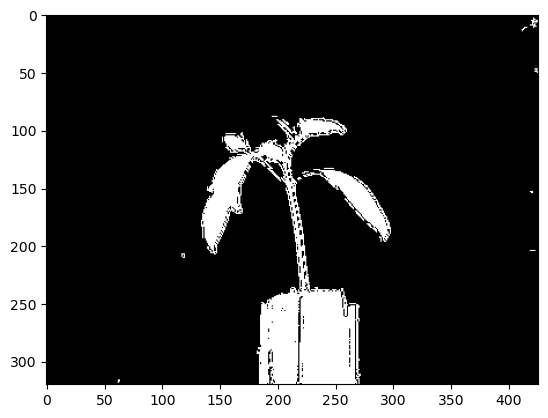

In [29]:
### Printing a test grayscale image to ensure that the grayscale images are saved correctly

test = df_copy['f_img_bw'][100]
plt.imshow(test.reshape((new_width, new_height)), cmap='gray')
plt.show()

In [30]:
### Transforming the lists to arrays to be used for classification later

start = time.time()


resize_img_bw_array = resize_img_bw_list[0]
lp_img_bw_array = lp_img_bw_list[0]
lp_shrp_img_bw_array = lp_shrp_img_bw_list[0]
sb_img_bw_array = sb_img_bw_list[0]
mblur_img_bw_array = mblur_img_bw_list[0]
mblur_invert_img_bw_array = mblur_invert_img_bw_list[0]
edge_shrp_img_bw_array = edge_shrp_img_bw_list[0]
tr_es_img_bw_array = tr_es_img_bw_list[0]
f_img_bw_array = f_img_bw_list[0]
eroded_img_bw_array = eroded_img_bw_list[0]
bx1234_img_bw_array = bx1234_img_bw_list[0]

for k in range(1,df_copy.shape[0]):
    
    intermediate_resize_img_bw = resize_img_bw_list[k]
    resize_img_bw_array = np.vstack((resize_img_bw_array,intermediate_resize_img_bw))
    
    intermediate_lp_img_bw = lp_img_bw_list[k]
    lp_img_bw_array = np.vstack((lp_img_bw_array, intermediate_lp_img_bw))
    
    intermediate_lp_shrp_img_bw = lp_shrp_img_bw_list[k]
    lp_shrp_img_bw_array = np.vstack((lp_shrp_img_bw_array, intermediate_lp_shrp_img_bw))  
    
    intermediate_sb_img_bw = sb_img_bw_list[k]
    sb_img_bw_array = np.vstack((sb_img_bw_array, intermediate_sb_img_bw))
    
    intermediate_mblur_img_bw = mblur_img_bw_list[k]
    mblur_img_bw_array = np.vstack((mblur_img_bw_array, intermediate_mblur_img_bw))
    
    intermediate_mblur_invert_img_bw = mblur_invert_img_bw_list[k]
    mblur_invert_img_bw_array = np.vstack((mblur_invert_img_bw_array, intermediate_mblur_invert_img_bw))
    
    intermediate_edge_shrp_img_bw = edge_shrp_img_bw_list[k]
    edge_shrp_img_bw_array = np.vstack((edge_shrp_img_bw_array, intermediate_edge_shrp_img_bw))
    
    intermediate_tr_es_img_bw = tr_es_img_bw_list[k]
    tr_es_img_bw_array = np.vstack((tr_es_img_bw_array, intermediate_tr_es_img_bw))
    
    intermediate_f_img_bw = f_img_bw_list[k]
    f_img_bw_array = np.vstack((f_img_bw_array, intermediate_f_img_bw))
    
    intermediate_eroded_img_bw = eroded_img_bw_list[k]
    eroded_img_bw_array = np.vstack((eroded_img_bw_array, intermediate_eroded_img_bw))

    intermediate_bx1234_img_bw = bx1234_img_bw_list[k]
    bx1234_img_bw_array = np.vstack((bx1234_img_bw_array, intermediate_bx1234_img_bw))
    
    
end = time.time()    

print(f"The time to run this cell in seconds is: {end - start}") ### typically around 320 seconds

The time to run this cell in seconds is: 321.00643253326416


In [31]:
resize_img_bw_array.shape

(994, 136320)

In [32]:
lp_img_bw_array.shape

(994, 136320)

In [33]:
all_features_nir = np.hstack((resize_img_bw_array,
                              lp_img_bw_array,
                              lp_shrp_img_bw_array,
                              sb_img_bw_array,
                              mblur_img_bw_array,
                              mblur_invert_img_bw_array,
                              edge_shrp_img_bw_array,
                              tr_es_img_bw_array,
                              f_img_bw_array,
                              eroded_img_bw_array,
                              bx1234_img_bw_array))

# The tutorials from PlantCV have ended, from now on we move to feature extraction

In [34]:
all_features_nir.shape

(994, 1499520)

In [35]:
all_features_vis.shape

(994, 1499520)

In [36]:
### Concatenating all the RGB and Grayscale features (flattened image arrays)

start = time.time()

all_features = np.hstack((all_features_vis, all_features_nir))

end = time.time()

print(f'The time to stack all features was: {end-start} seconds')

The time to stack all features was: 6.061525344848633 seconds


In [37]:
all_features.shape

(994, 2999040)

994, 2999040

# Dimensionality Reduction

## KernelPCA

In [ ]:
### Kernel PCA performs PCA dimensionality rediction through the use of kernels
### It is used because the normal PCA runs in 20 minutes for all features, while KernelPCA runs in about 4-5 (because of randomized eigen_solver)
### link: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html


start = time.time()

kpca = KernelPCA(n_components=100, random_state=42, eigen_solver='randomized')

all_features_kpca = kpca.fit_transform(all_features)

end = time.time()

print(f'The time to run the PCA was: {end-start} seconds or {(end-start)//60} minutes') ### 5 minutes for KPCA

In [ ]:
#np.save('all_features_kpca.npy', all_features_kpca)

The Truncated SVD and the regular PCA take too long to run (20 minutes each) so they are commented out. Only the KernelPCA components were used in the final classification

## Truncated SVD

In [32]:
### truncatedSVD is commented because it runs too slow, and using the Truncated SVD features does not provide better results than KPCA


# start = time.time()

# svd = TruncatedSVD(n_components=100, random_state=42)

# all_features_svd = svd.fit_transform(all_features)

# end = time.time()

# print(f'The time to run the PCA was: {end-start} seconds or {(end-start)//60} minutes') ### 20 minutes for regular Truncated SVD

The time to run the PCA was: 1856.601036787033 seconds or 30.0 minutes


In [34]:
# all_features_svd.shape

(994, 100)

In [33]:
# np.save('all_features_svd.npy', all_features_svd)

In [35]:
# all_features_svd = np.load('all_features_svd.npy')

In [36]:
# all_features_svd.shape

(994, 100)

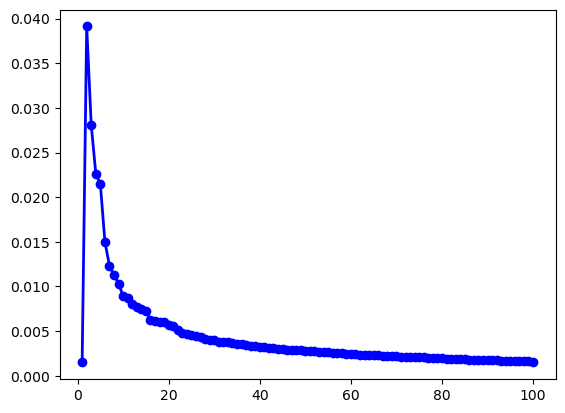

In [38]:
# PC_cb_values = np.arange(svd.n_components) + 1
# PC_sb_values = np.arange(svd.n_components) + 1

# plt.plot(PC_cb_values, svd.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

In [39]:
# svd.explained_variance_ratio_.cumsum()

array([0.00149061, 0.04061266, 0.06867875, 0.0913201 , 0.11279478,
       0.12779125, 0.14011845, 0.15139993, 0.16171062, 0.17063056,
       0.17933113, 0.18742686, 0.19515918, 0.20266173, 0.20990186,
       0.21620151, 0.2223706 , 0.22842717, 0.23446283, 0.24013598,
       0.24567346, 0.25079939, 0.25559534, 0.26029038, 0.26487603,
       0.2693295 , 0.27372406, 0.27782784, 0.28186834, 0.28582096,
       0.28965255, 0.29347132, 0.29724662, 0.30095846, 0.30448944,
       0.30800098, 0.31140211, 0.31477001, 0.31808889, 0.32130542,
       0.32451814, 0.32761162, 0.330669  , 0.33370652, 0.33669203,
       0.33963325, 0.34256714, 0.345454  , 0.34829318, 0.35109488,
       0.3538849 , 0.35662694, 0.35929882, 0.36195224, 0.36456885,
       0.36714353, 0.36968794, 0.372192  , 0.37465606, 0.37709007,
       0.37949073, 0.38183575, 0.38416085, 0.38647567, 0.38876827,
       0.39104445, 0.39329906, 0.39553054, 0.39775114, 0.39991143,
       0.40206226, 0.4041973 , 0.40629832, 0.40837878, 0.41043

## PCA

In [7]:
# start = time.time()

# pca = PCA(n_components=100)

# all_features_pca = pca.fit_transform(all_features)

# end = time.time()

# print(f'The time to run the PCA was: {end-start} seconds or {(end-start)//60} minutes') ### 20 minutes for regular PCA

The time to run the PCA was: 1319.5560369491577 seconds or 21.0 minutes


In [8]:
# all_features_pca.shape

(994, 100)

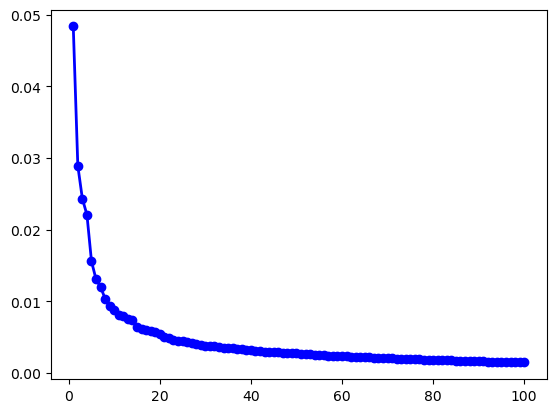

In [9]:
# PC_cb_values = np.arange(pca.n_components_) + 1
# PC_sb_values = np.arange(pca.n_components_) + 1

# plt.plot(PC_cb_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

In [10]:
# pca.explained_variance_ratio_.cumsum()

array([0.04837536, 0.07729622, 0.10163102, 0.12373864, 0.13934012,
       0.15244   , 0.16444004, 0.17483742, 0.1842627 , 0.19300945,
       0.2011789 , 0.20911764, 0.21662423, 0.22407247, 0.23045909,
       0.23664455, 0.24264342, 0.24851303, 0.25420098, 0.2596434 ,
       0.26466849, 0.2695062 , 0.274194  , 0.27870461, 0.28315352,
       0.28752985, 0.29166826, 0.29573481, 0.2996656 , 0.30351391,
       0.30729622, 0.31103878, 0.3146843 , 0.31825036, 0.32174524,
       0.32522587, 0.32858564, 0.33189321, 0.33508127, 0.33824969,
       0.34132945, 0.34437296, 0.34736855, 0.35031681, 0.35324572,
       0.35614788, 0.35899333, 0.36180722, 0.36459682, 0.36734415,
       0.37006992, 0.3727273 , 0.37534172, 0.37792799, 0.38048323,
       0.38298993, 0.38542995, 0.38784373, 0.3902226 , 0.39258266,
       0.39493714, 0.39724445, 0.3994948 , 0.40172831, 0.40395316,
       0.40614675, 0.40831429, 0.41044446, 0.41257092, 0.4146752 ,
       0.41673556, 0.41876856, 0.42079934, 0.422805  , 0.42477

In [11]:
# type(all_features_pca)

numpy.ndarray

In [14]:
# np.save('all_features_pca.npy', all_features_pca)

In [15]:
# all_features_pca = np.load('all_features_pca.npy')

In [16]:
# all_features_pca.shape

(994, 100)

# numpy saving data

We have saved all the following arrays when the notebook was first run, so the following np.save cells are commented out since there is no need to overwrite the arrays. The saved arrays are provided, so we only need to load them with np.load

If it is decided to save the arrays, please do take note that they take up close to 2.5 GB of disk space.

## saving the experts labels

In [ ]:
np.save("inter_y1.npy", inter_y1)
np.save("inter_y2.npy", inter_y2)
np.save("inter_y3.npy", inter_y3)
np.save("inter_y4.npy", inter_y4)

### Saving vis features

In [43]:
np.save("resize_img_array.npy", resize_img_array)
np.save("analysis_image_array.npy", analysis_image_array)
np.save("s_thresh_image_array.npy", s_thresh_image_array)
np.save("b_thresh_image_array.npy", b_thresh_image_array)
np.save("bs_image_array.npy", bs_image_array)
np.save("xor_img_image_array.npy", xor_img_image_array)
np.save("closed_ab_image_array.npy", closed_ab_image_array)


### Saving the nir features

In [44]:
### Uncomment to save the arrays

np.save("resize_img_bw_array.npy", resize_img_bw_array)
np.save("lp_img_bw_array.npy", lp_img_bw_array)
np.save("lp_shrp_img_bw_array.npy", lp_shrp_img_bw_array)
np.save("sb_img_bw_array.npy", sb_img_bw_array)
np.save("mblur_img_bw_array.npy", mblur_img_bw_array)
np.save("mblur_invert_img_bw_array.npy", mblur_invert_img_bw_array)
np.save("edge_shrp_img_bw_array.npy", edge_shrp_img_bw_array)
np.save("tr_es_img_bw_array.npy", tr_es_img_bw_array)
np.save("f_img_bw_array.npy", f_img_bw_array)
np.save("eroded_img_bw_array.npy", eroded_img_bw_array)
np.save("bx1234_img_bw_array.npy", bx1234_img_bw_array)


# Usually, because the matrices are very big in size, Python throws a memory allocation error in one of the next cells. If this happens, we can restart the kernel HERE (make sure that all the arrays are saved correctly above). This is why we re-calculate the dataframe as before.

In [1]:
import pandas as pd
import csv
import os
from plantcv import plantcv as pcv
import time
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA, KernelPCA
from imblearn.over_sampling import RandomOverSampler
import h5py

In [2]:
print(pcv.__version__)
#print(pcv.__file__)

3.14.2


In [3]:
%matplotlib inline

In [4]:
# Enter path to the data_fusion_guest_lecture file
image_folder_path = ""

# Loads labels
df = pd.read_csv(os.path.join(image_folder_path, "seedling_labels.csv"))

# Creates path to top & side view
df["color_cam_path"] = image_folder_path  + df["color_cam_path"]
df["side_cam_path"] = image_folder_path  + df["side_cam_path"]

# Gives average expert label as a starting point
df["average_expert"] = (df["Expert 1"] + df["Expert 2"]  + df["Expert 3"] + df["Expert 4"]) / 4
#df.head()

In [5]:
class options:
    def __init__(self):
        self.image = df['color_cam_path'][1]
        self.background = df['side_cam_path'][1]
        self.debug = None
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug



In [6]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

In [7]:
img, path, filename = pcv.readimage(filename=args.background)

In [8]:
width = img.shape[0]
height = img.shape[1]

In [9]:
df_copy = df.copy()

In [10]:
### Setting the correct classes for every expert

df_copy.loc[df_copy['Expert 1']<3, 'Expert 1'] = 1
df_copy.loc[df_copy['Expert 2']<3, 'Expert 2'] = 1
df_copy.loc[df_copy['Expert 3']<3, 'Expert 3'] = 1
df_copy.loc[df_copy['Expert 4']<3, 'Expert 4'] = 1

df_copy.loc[df_copy['Expert 1']>=3, 'Expert 1'] = 0
df_copy.loc[df_copy['Expert 2']>=3, 'Expert 2'] = 0
df_copy.loc[df_copy['Expert 3']>=3, 'Expert 3'] = 0
df_copy.loc[df_copy['Expert 4']>=3, 'Expert 4'] = 0


# Loading the arrays again in order to implement the various models

In [11]:
inter_y1 = np.load('inter_y1.npy')
inter_y2 = np.load('inter_y2.npy')
inter_y3 = np.load('inter_y3.npy')
inter_y4 = np.load('inter_y4.npy')

In [12]:
resize_img_array =  np.load('resize_img_array.npy')
analysis_image_array =  np.load('analysis_image_array.npy')
s_thresh_image_array =  np.load('s_thresh_image_array.npy')
b_thresh_image_array =  np.load('b_thresh_image_array.npy')
bs_image_array =  np.load('bs_image_array.npy')
xor_img_image_array =  np.load('xor_img_image_array.npy')
closed_ab_image_array =  np.load('closed_ab_image_array.npy')

In [13]:
resize_img_bw_array =  np.load('resize_img_bw_array.npy')
lp_img_bw_array =  np.load('lp_img_bw_array.npy')
lp_shrp_img_bw_array =  np.load('lp_shrp_img_bw_array.npy')
sb_img_bw_array =  np.load('sb_img_bw_array.npy')
mblur_img_bw_array =  np.load('mblur_img_bw_array.npy')
mblur_invert_img_bw_array =  np.load('mblur_invert_img_bw_array.npy')
edge_shrp_img_bw_array =  np.load('edge_shrp_img_bw_array.npy')
tr_es_img_bw_array =  np.load('tr_es_img_bw_array.npy')
f_img_bw_array =  np.load('f_img_bw_array.npy')
eroded_img_bw_array =  np.load('eroded_img_bw_array.npy')
bx1234_img_bw_array =  np.load('bx1234_img_bw_array.npy')

In [14]:
# If this cell is run, it consumes a lot of RAM so it is commented out, since it not used later

# all_features_vis = np.hstack((resize_img_array,
#                               analysis_image_array, 
#                               s_thresh_image_array, 
#                               b_thresh_image_array,
#                               bs_image_array,
#                               xor_img_image_array,
#                               closed_ab_image_array))


# all_features_nir = np.hstack((resize_img_bw_array,
#                               lp_img_bw_array,
#                               lp_shrp_img_bw_array,
#                               sb_img_bw_array,
#                               mblur_img_bw_array,
#                               mblur_invert_img_bw_array,
#                               edge_shrp_img_bw_array,
#                               tr_es_img_bw_array,
#                               f_img_bw_array,
#                               eroded_img_bw_array,
#                               bx1234_img_bw_array))

# all_features = np.hstack((all_features_vis, all_features_nir))

In [15]:
# all_features.shape

In [16]:
### Do not run this cell twice

df_copy.loc[df_copy['average_expert']<3, 'average_expert'] = 1
df_copy.loc[df_copy['average_expert']>=3, 'average_expert'] = 0

inter_y_average_high = df_copy['average_expert'].to_numpy().reshape(-1,1)
inter_y_average_high.shape

(994, 1)

(994, 1)

 In each scenario, 3 models are used: Random Forests, Logistic Regression and Decision Trees

# Expert Fusion


### High Level Expert Fusion: 1 Majority Expert, with color images (High level Fusion)


### The data is split into train, validation and test sets.
### For each Expert we build a separate model, which is trained on his own labels on the train set (the X are the same, but the labels differ from Expert to Expert.
### Then, each model is validated on the respective labels from that Expert on the validation set (again, same X_validation but different y_validation labels)
### Then, the models are fused: The 4 models each make a separate decision for the test set.
### The final accuracy metrics are measured on the original average expert column of the dataframe (converted to binary 0,1 instead of 1,2,3,4 classes, because the fused model cannot be tested against individual labels from Experts

### Because the 2 classes are imbalanced, oversampling will be performed. Imbalanced learn random oversampler needs the target values to be in a (n,1) vector, so in order to not lose the original indexing of the variables, the y values are horizontally stacked to the X variables, and will afterwards be splitted again

In [17]:
inter_features_high = np.hstack((resize_img_array, inter_y1, inter_y2, inter_y3, inter_y4))

print(inter_features_high.shape)

(994, 408964)


(994, 408964)



we need to run the cells in the beginning to load df_copy again if we restarted kernel

In [18]:
ros = RandomOverSampler(random_state=42)

X_res_high_majority, y_res_high_majority = ros.fit_resample(inter_features_high, inter_y_average_high)

print(X_res_high_majority.shape)
print(y_res_high_majority.shape)

(1486, 408964)
(1486,)


(1486, 408964)

(1486,)


In [19]:
X_res_high_majority_inter = X_res_high_majority[:, 0:X_res_high_majority.shape[1] - 4]
y_res_high_majority = X_res_high_majority[:, X_res_high_majority.shape[1]-4:X_res_high_majority.shape[1]]

X_res_high_majority = X_res_high_majority_inter
print(X_res_high_majority.shape)
print(y_res_high_majority.shape)

(1486, 408960)
(1486, 4)


In [20]:
X_train_high_majority, X_rem_high_majority, y_train_high_majority, y_rem_high_majority = train_test_split(X_res_high_majority, 
                                                                                                            y_res_high_majority, 
                                                                                                test_size=0.33, 
                                                                                                random_state=42)


In [21]:
X_val_high_majority, X_test_high_majority, y_val_high_majority, y_test_high_majority = train_test_split(X_rem_high_majority, 
                                                                                                        y_rem_high_majority, 
                                                                                                test_size=0.40,                       
                                                                                                random_state=42)


In [22]:
print(X_res_high_majority.shape)
print(y_res_high_majority.shape)
print('')
print(X_train_high_majority.shape)
print(y_train_high_majority.shape)
print('')
print(X_val_high_majority.shape)
print(y_val_high_majority.shape)
print('')
print(X_test_high_majority.shape)
print(y_test_high_majority.shape)
print('')



(1486, 408960)
(1486, 4)

(995, 408960)
(995, 4)

(294, 408960)
(294, 4)

(197, 408960)
(197, 4)



In [23]:
# Train
X1_train_high_majority = X_train_high_majority
X2_train_high_majority = X_train_high_majority
X3_train_high_majority = X_train_high_majority
X4_train_high_majority = X_train_high_majority

y1_train_high_majority = y_train_high_majority[:,0]
y2_train_high_majority = y_train_high_majority[:,1]
y3_train_high_majority = y_train_high_majority[:,2]
y4_train_high_majority = y_train_high_majority[:,3]

# Validation
X1_val_high_majority = X_val_high_majority
X2_val_high_majority = X_val_high_majority
X3_val_high_majority = X_val_high_majority
X4_val_high_majority = X_val_high_majority

y1_val_high_majority = y_val_high_majority[:,0]
y2_val_high_majority = y_val_high_majority[:,1]
y3_val_high_majority = y_val_high_majority[:,2]
y4_val_high_majority = y_val_high_majority[:,3]

# Test
X1_test_high_majority = X_test_high_majority 
X2_test_high_majority = X_test_high_majority 
X3_test_high_majority = X_test_high_majority 
X4_test_high_majority = X_test_high_majority 




In [24]:
print(y_test_high_majority.shape)

y_test_high_majority_single = []

for i in range(y_test_high_majority.shape[0]):
    final_label1 = y_test_high_majority[i,0]
    final_label2 = y_test_high_majority[i,1]
    final_label3 = y_test_high_majority[i,2]
    final_label4 = y_test_high_majority[i,3]
    if np.sum([final_label1, final_label2, final_label3, final_label4]) <= 2:
        majority_label = 0
    else:
        majority_label = 1
    y_test_high_majority_single.append(majority_label)   


y_test_high_majority_single = np.array(y_test_high_majority_single)

print(y_test_high_majority_single.shape)

(197, 4)
(197,)


### Random Forest

In [27]:
start1 = time.time()

names = 'Random Forest'

classifiers = RandomForestClassifier(random_state=42)

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST\033[0m\n')
clf1_high_majority = RandomForestClassifier(random_state=42)
clf2_high_majority = RandomForestClassifier(random_state=42)
clf3_high_majority = RandomForestClassifier(random_state=42)
clf4_high_majority = RandomForestClassifier(random_state=42)

clf1_high_majority.fit(X1_train_high_majority, y1_train_high_majority)
clf2_high_majority.fit(X2_train_high_majority, y2_train_high_majority)
clf3_high_majority.fit(X3_train_high_majority, y3_train_high_majority)
clf4_high_majority.fit(X4_train_high_majority, y4_train_high_majority)

preds1_high_majority = clf1_high_majority.predict(X1_val_high_majority)
preds2_high_majority = clf2_high_majority.predict(X2_val_high_majority)
preds3_high_majority = clf3_high_majority.predict(X3_val_high_majority)
preds4_high_majority = clf4_high_majority.predict(X4_val_high_majority)

print(classification_report(y1_val_high_majority,preds1_high_majority))
print('-'*100)
print(classification_report(y2_val_high_majority,preds2_high_majority))
print('-'*100)
print(classification_report(y3_val_high_majority,preds3_high_majority))
print('-'*100)
print(classification_report(y4_val_high_majority,preds4_high_majority))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ") ### typically 2-3 minutes


SHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       167
           1       0.94      0.94      0.94       127

    accuracy                           0.95       294
   macro avg       0.94      0.94      0.94       294
weighted avg       0.95      0.95      0.95       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       172
           1       0.92      0.95      0.94       122

    accuracy                           0.95       294
   macro avg       0.94      0.95      0.94       294
weighted avg       0.95      0.95      0.95       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.9

In [28]:
test_preds1_high_majority = clf1_high_majority.predict(X1_test_high_majority)
test_preds2_high_majority = clf2_high_majority.predict(X2_test_high_majority)
test_preds3_high_majority = clf3_high_majority.predict(X3_test_high_majority)
test_preds4_high_majority = clf4_high_majority.predict(X4_test_high_majority)

In [29]:
final_test_predictions_high_majority = []

for i in range(test_preds1_high_majority.shape[0]):
    sum_labels = np.sum([test_preds1_high_majority[i], test_preds2_high_majority[i], test_preds3_high_majority[i], test_preds4_high_majority[i]])
    if sum_labels <= 2:
        final_label = 0
    else:
        final_label = 1
        
    final_test_predictions_high_majority.append(final_label)
    
final_test_predictions_high_majority = np.array(final_test_predictions_high_majority)

print(final_test_predictions_high_majority.shape)

(197,)


In [30]:
print(classification_report(y_test_high_majority_single, final_test_predictions_high_majority))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        99
           1       0.97      0.97      0.97        98

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



### Logistic Regression

In [33]:
start1 = time.time()

names = 'LOGISTIC REGRESSION'

classifiers = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION\033[0m\n')
clf1_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf2_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf3_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf4_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

clf1_high_majority.fit(X1_train_high_majority, y1_train_high_majority)
clf2_high_majority.fit(X2_train_high_majority, y2_train_high_majority)
clf3_high_majority.fit(X3_train_high_majority, y3_train_high_majority)
clf4_high_majority.fit(X4_train_high_majority, y4_train_high_majority)

preds1_high_majority = clf1_high_majority.predict(X1_val_high_majority)
preds2_high_majority = clf2_high_majority.predict(X2_val_high_majority)
preds3_high_majority = clf3_high_majority.predict(X3_val_high_majority)
preds4_high_majority = clf4_high_majority.predict(X4_val_high_majority)

print(classification_report(y1_val_high_majority,preds1_high_majority))
print('-'*100)
print(classification_report(y2_val_high_majority,preds2_high_majority))
print('-'*100)
print(classification_report(y3_val_high_majority,preds3_high_majority))
print('-'*100)
print(classification_report(y4_val_high_majority,preds4_high_majority))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       167
           1       0.95      0.87      0.91       127

    accuracy                           0.92       294
   macro avg       0.93      0.92      0.92       294
weighted avg       0.92      0.92      0.92       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       172
           1       0.93      0.89      0.91       122

    accuracy                           0.93       294
   macro avg       0.93      0.92      0.93       294
weighted avg       0.93      0.93      0.93       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96   

In [34]:
test_preds1_high_majority = clf1_high_majority.predict(X1_test_high_majority)
test_preds2_high_majority = clf2_high_majority.predict(X2_test_high_majority)
test_preds3_high_majority = clf3_high_majority.predict(X3_test_high_majority)
test_preds4_high_majority = clf4_high_majority.predict(X4_test_high_majority)

In [35]:
final_test_predictions_high_majority = []

for i in range(test_preds1_high_majority.shape[0]):
    sum_labels = np.sum([test_preds1_high_majority[i], test_preds2_high_majority[i], test_preds3_high_majority[i], test_preds4_high_majority[i]])
    if sum_labels <= 2:
        final_label = 0
    else:
        final_label = 1
        
    final_test_predictions_high_majority.append(final_label)
    
final_test_predictions_high_majority = np.array(final_test_predictions_high_majority)

print(final_test_predictions_high_majority.shape)

(197,)


In [36]:
print(classification_report(y_test_high_majority_single, final_test_predictions_high_majority))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        99
           1       0.98      0.93      0.95        98

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197



### Decision Trees

In [38]:
start1 = time.time()

names = 'Decision Trees'

classifiers = DecisionTreeClassifier(criterion='entropy', random_state=42)

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: DECISION TREES\033[0m\n')
clf1_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf2_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf3_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf4_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf1_high_majority.fit(X1_train_high_majority, y1_train_high_majority)
clf2_high_majority.fit(X2_train_high_majority, y2_train_high_majority)
clf3_high_majority.fit(X3_train_high_majority, y3_train_high_majority)
clf4_high_majority.fit(X4_train_high_majority, y4_train_high_majority)

preds1_high_majority = clf1_high_majority.predict(X1_val_high_majority)
preds2_high_majority = clf2_high_majority.predict(X2_val_high_majority)
preds3_high_majority = clf3_high_majority.predict(X3_val_high_majority)
preds4_high_majority = clf4_high_majority.predict(X4_val_high_majority)

print(classification_report(y1_val_high_majority,preds1_high_majority))
print('-'*100)
print(classification_report(y2_val_high_majority,preds2_high_majority))
print('-'*100)
print(classification_report(y3_val_high_majority,preds3_high_majority))
print('-'*100)
print(classification_report(y4_val_high_majority,preds4_high_majority))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: DECISION TREES

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       167
           1       0.89      0.83      0.86       127

    accuracy                           0.88       294
   macro avg       0.88      0.87      0.88       294
weighted avg       0.88      0.88      0.88       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       172
           1       0.83      0.80      0.82       122

    accuracy                           0.85       294
   macro avg       0.85      0.84      0.85       294
weighted avg       0.85      0.85      0.85       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.95      0.

In [39]:
test_preds1_high_majority = clf1_high_majority.predict(X1_test_high_majority)
test_preds2_high_majority = clf2_high_majority.predict(X2_test_high_majority)
test_preds3_high_majority = clf3_high_majority.predict(X3_test_high_majority)
test_preds4_high_majority = clf4_high_majority.predict(X4_test_high_majority)

In [40]:
final_test_predictions_high_majority = []

for i in range(test_preds1_high_majority.shape[0]):
    sum_labels = np.sum([test_preds1_high_majority[i], test_preds2_high_majority[i], test_preds3_high_majority[i], test_preds4_high_majority[i]])
    if sum_labels <= 2:
        final_label = 0
    else:
        final_label = 1
        
    final_test_predictions_high_majority.append(final_label)
    
final_test_predictions_high_majority = np.array(final_test_predictions_high_majority)

print(final_test_predictions_high_majority.shape)

(197,)


In [41]:
print(classification_report(y_test_high_majority_single, final_test_predictions_high_majority))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        99
           1       0.98      0.88      0.92        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



## 1 Majority Expert, using resized RGB and BW images concatenated as features

In [25]:
im_rbg_bw = np.hstack((resize_img_array, resize_img_bw_array))

In [26]:
inter_features_high = np.hstack((im_rbg_bw, inter_y1, inter_y2, inter_y3, inter_y4))

print(inter_features_high.shape)

(994, 545284)


(994, 545284)


we need to run the cells in the beginning to load df_copy again if we restarted kernel

In [27]:

# df_copy.loc[df_copy['average_expert']<3, 'average_expert'] = 1
# df_copy.loc[df_copy['average_expert']>=3, 'average_expert'] = 0

inter_y_average_high = df_copy['average_expert'].to_numpy().reshape(-1,1)
inter_y_average_high.shape

(994, 1)

In [28]:
ros = RandomOverSampler(random_state=42)

X_res_high_majority, y_res_high_majority = ros.fit_resample(inter_features_high, inter_y_average_high)

print(X_res_high_majority.shape)
print(y_res_high_majority.shape)

(1486, 545284)
(1486,)


(1486, 545284)

(1486,)


In [29]:
X_res_high_majority_inter = X_res_high_majority[:, 0:X_res_high_majority.shape[1] - 4]
y_res_high_majority = X_res_high_majority[:, X_res_high_majority.shape[1]-4:X_res_high_majority.shape[1]]

X_res_high_majority = X_res_high_majority_inter
print(X_res_high_majority.shape)
print(y_res_high_majority.shape)

(1486, 545280)
(1486, 4)


In [30]:
X_train_high_majority, X_rem_high_majority, y_train_high_majority, y_rem_high_majority = train_test_split(X_res_high_majority, 
                                                                                                            y_res_high_majority, 
                                                                                                test_size=0.33, 
                                                                                                random_state=42)


In [31]:
X_val_high_majority, X_test_high_majority, y_val_high_majority, y_test_high_majority = train_test_split(X_rem_high_majority, 
                                                                                                        y_rem_high_majority, 
                                                                                                test_size=0.40,                       
                                                                                                random_state=42)


In [32]:
print(X_res_high_majority.shape)
print(y_res_high_majority.shape)
print('')
print(X_train_high_majority.shape)
print(y_train_high_majority.shape)
print('')
print(X_val_high_majority.shape)
print(y_val_high_majority.shape)
print('')
print(X_test_high_majority.shape)
print(y_test_high_majority.shape)
print('')



(1486, 545280)
(1486, 4)

(995, 545280)
(995, 4)

(294, 545280)
(294, 4)

(197, 545280)
(197, 4)



In [33]:
# Train
X1_train_high_majority = X_train_high_majority
X2_train_high_majority = X_train_high_majority
X3_train_high_majority = X_train_high_majority
X4_train_high_majority = X_train_high_majority

y1_train_high_majority = y_train_high_majority[:,0]
y2_train_high_majority = y_train_high_majority[:,1]
y3_train_high_majority = y_train_high_majority[:,2]
y4_train_high_majority = y_train_high_majority[:,3]

# Validation
X1_val_high_majority = X_val_high_majority
X2_val_high_majority = X_val_high_majority
X3_val_high_majority = X_val_high_majority
X4_val_high_majority = X_val_high_majority

y1_val_high_majority = y_val_high_majority[:,0]
y2_val_high_majority = y_val_high_majority[:,1]
y3_val_high_majority = y_val_high_majority[:,2]
y4_val_high_majority = y_val_high_majority[:,3]

# Test
X1_test_high_majority = X_test_high_majority 
X2_test_high_majority = X_test_high_majority 
X3_test_high_majority = X_test_high_majority 
X4_test_high_majority = X_test_high_majority 




In [34]:
print(y_test_high_majority.shape)

y_test_high_majority_single = []

for i in range(y_test_high_majority.shape[0]):
    final_label1 = y_test_high_majority[i,0]
    final_label2 = y_test_high_majority[i,1]
    final_label3 = y_test_high_majority[i,2]
    final_label4 = y_test_high_majority[i,3]
    if np.sum([final_label1, final_label2, final_label3, final_label4]) <= 2:
        majority_label = 0
    else:
        majority_label = 1
    y_test_high_majority_single.append(majority_label)   


y_test_high_majority_single = np.array(y_test_high_majority_single)

print(y_test_high_majority_single.shape)

(197, 4)
(197,)


### Random Forest

In [28]:
start1 = time.time()

names = 'Random Forest'

classifiers = RandomForestClassifier(random_state=42)

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST\033[0m\n')
clf1_high_majority = RandomForestClassifier(random_state=42)
clf2_high_majority = RandomForestClassifier(random_state=42)
clf3_high_majority = RandomForestClassifier(random_state=42)
clf4_high_majority = RandomForestClassifier(random_state=42)

clf1_high_majority.fit(X1_train_high_majority, y1_train_high_majority)
clf2_high_majority.fit(X2_train_high_majority, y2_train_high_majority)
clf3_high_majority.fit(X3_train_high_majority, y3_train_high_majority)
clf4_high_majority.fit(X4_train_high_majority, y4_train_high_majority)

preds1_high_majority = clf1_high_majority.predict(X1_val_high_majority)
preds2_high_majority = clf2_high_majority.predict(X2_val_high_majority)
preds3_high_majority = clf3_high_majority.predict(X3_val_high_majority)
preds4_high_majority = clf4_high_majority.predict(X4_val_high_majority)

print(classification_report(y1_val_high_majority,preds1_high_majority))
print('-'*100)
print(classification_report(y2_val_high_majority,preds2_high_majority))
print('-'*100)
print(classification_report(y3_val_high_majority,preds3_high_majority))
print('-'*100)
print(classification_report(y4_val_high_majority,preds4_high_majority))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ") ### typically 2-3 minutes


SHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       167
           1       0.93      0.97      0.95       127

    accuracy                           0.96       294
   macro avg       0.95      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       172
           1       0.91      0.96      0.94       122

    accuracy                           0.95       294
   macro avg       0.94      0.95      0.94       294
weighted avg       0.95      0.95      0.95       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.9

In [29]:
test_preds1_high_majority = clf1_high_majority.predict(X1_test_high_majority)
test_preds2_high_majority = clf2_high_majority.predict(X2_test_high_majority)
test_preds3_high_majority = clf3_high_majority.predict(X3_test_high_majority)
test_preds4_high_majority = clf4_high_majority.predict(X4_test_high_majority)

In [30]:
final_test_predictions_high_majority = []

for i in range(test_preds1_high_majority.shape[0]):
    sum_labels = np.sum([test_preds1_high_majority[i], test_preds2_high_majority[i], test_preds3_high_majority[i], test_preds4_high_majority[i]])
    if sum_labels <= 2:
        final_label = 0
    else:
        final_label = 1
        
    final_test_predictions_high_majority.append(final_label)
    
final_test_predictions_high_majority = np.array(final_test_predictions_high_majority)

print(final_test_predictions_high_majority.shape)

(197,)


In [31]:
print(classification_report(y_test_high_majority_single, final_test_predictions_high_majority))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95        99
           1       0.95      0.96      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



### Logistic Regression

In [ ]:
start1 = time.time() ### this cell takes too long to run because the concatenated images have a lot of features, so train takes too long

names = 'LOGISTIC REGRESSION'

classifiers = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION\033[0m\n')
clf1_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf2_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf3_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf4_high_majority =  LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

clf1_high_majority.fit(X1_train_high_majority, y1_train_high_majority)
clf2_high_majority.fit(X2_train_high_majority, y2_train_high_majority)
clf3_high_majority.fit(X3_train_high_majority, y3_train_high_majority)
clf4_high_majority.fit(X4_train_high_majority, y4_train_high_majority)

preds1_high_majority = clf1_high_majority.predict(X1_val_high_majority)
preds2_high_majority = clf2_high_majority.predict(X2_val_high_majority)
preds3_high_majority = clf3_high_majority.predict(X3_val_high_majority)
preds4_high_majority = clf4_high_majority.predict(X4_val_high_majority)

print(classification_report(y1_val_high_majority,preds1_high_majority))
print('-'*100)
print(classification_report(y2_val_high_majority,preds2_high_majority))
print('-'*100)
print(classification_report(y3_val_high_majority,preds3_high_majority))
print('-'*100)
print(classification_report(y4_val_high_majority,preds4_high_majority))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION



In [ ]:
test_preds1_high_majority = clf1_high_majority.predict(X1_test_high_majority)
test_preds2_high_majority = clf2_high_majority.predict(X2_test_high_majority)
test_preds3_high_majority = clf3_high_majority.predict(X3_test_high_majority)
test_preds4_high_majority = clf4_high_majority.predict(X4_test_high_majority)

In [ ]:
final_test_predictions_high_majority = []

for i in range(test_preds1_high_majority.shape[0]):
    sum_labels = np.sum([test_preds1_high_majority[i], test_preds2_high_majority[i], test_preds3_high_majority[i], test_preds4_high_majority[i]])
    if sum_labels <= 2:
        final_label = 0
    else:
        final_label = 1
        
    final_test_predictions_high_majority.append(final_label)
    
final_test_predictions_high_majority = np.array(final_test_predictions_high_majority)

print(final_test_predictions_high_majority.shape)

In [ ]:
print(classification_report(y_test_high_majority_single, final_test_predictions_high_majority))

### Decision Trees

In [ ]:
start1 = time.time() ### Tis cell takes too long to run because the concatenated images have a lot of features

names = 'Decision Trees'

classifiers = DecisionTreeClassifier(criterion='entropy', random_state=42)

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: DECISION TREES\033[0m\n')
clf1_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf2_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf3_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf4_high_majority = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf1_high_majority.fit(X1_train_high_majority, y1_train_high_majority)
clf2_high_majority.fit(X2_train_high_majority, y2_train_high_majority)
clf3_high_majority.fit(X3_train_high_majority, y3_train_high_majority)
clf4_high_majority.fit(X4_train_high_majority, y4_train_high_majority)

preds1_high_majority = clf1_high_majority.predict(X1_val_high_majority)
preds2_high_majority = clf2_high_majority.predict(X2_val_high_majority)
preds3_high_majority = clf3_high_majority.predict(X3_val_high_majority)
preds4_high_majority = clf4_high_majority.predict(X4_val_high_majority)

print(classification_report(y1_val_high_majority,preds1_high_majority))
print('-'*100)
print(classification_report(y2_val_high_majority,preds2_high_majority))
print('-'*100)
print(classification_report(y3_val_high_majority,preds3_high_majority))
print('-'*100)
print(classification_report(y4_val_high_majority,preds4_high_majority))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


In [ ]:
test_preds1_high_majority = clf1_high_majority.predict(X1_test_high_majority)
test_preds2_high_majority = clf2_high_majority.predict(X2_test_high_majority)
test_preds3_high_majority = clf3_high_majority.predict(X3_test_high_majority)
test_preds4_high_majority = clf4_high_majority.predict(X4_test_high_majority)

In [ ]:
final_test_predictions_high_majority = []

for i in range(test_preds1_high_majority.shape[0]):
    sum_labels = np.sum([test_preds1_high_majority[i], test_preds2_high_majority[i], test_preds3_high_majority[i], test_preds4_high_majority[i]])
    if sum_labels <= 2:
        final_label = 0
    else:
        final_label = 1
        
    final_test_predictions_high_majority.append(final_label)
    
final_test_predictions_high_majority = np.array(final_test_predictions_high_majority)

print(final_test_predictions_high_majority.shape)

In [ ]:
print(classification_report(y_test_high_majority_single, final_test_predictions_high_majority))

## 1 Majority Expert, using KernelPCA for features instead of raw images
## Again, each Expert has their own model, which is trained on the respective Expert labels, and validated on the validation set. Then, the final test prediction is done via majority voting

### loading the kpca features

In [35]:
all_features_kpca = np.load('all_features_kpca.npy')

print(all_features_kpca.shape)

(994, 100)


Because the 2 classes are imbalanced, oversampling will be performed. Imbalanced learn random oversampler needs the target values to be in a (n,1) vector, so in order to not lose the original indexing of the variables, the y values are horizontally stacked to the X variables, and will afterwards be splitted again

In [36]:
inter_features_mid_kpca = np.hstack((all_features_kpca, inter_y1, inter_y2, inter_y3, inter_y4))

print(inter_features_mid_kpca.shape)

(994, 104)


(994, 104)


we need to run the cells in the beginning to load df_copy again if we restarted kernel

In [37]:

#df_copy.loc[df_copy['average_expert']<3, 'average_expert'] = 1 
#df_copy.loc[df_copy['average_expert']>=3, 'average_expert'] = 0

inter_y_average_mid = df_copy['average_expert'].to_numpy().reshape(-1,1)
inter_y_average_mid.shape

(994, 1)

In [38]:
ros = RandomOverSampler(random_state=42)

X_res_mid_majority_kpca, y_res_mid_majority = ros.fit_resample(inter_features_mid_kpca, inter_y_average_mid)

print(X_res_mid_majority_kpca.shape)
print(y_res_mid_majority.shape)

(1486, 104)
(1486,)


(1486, 104)

(1486,)


In [39]:
X_res_mid_majority_kpca_inter = X_res_mid_majority_kpca[:, 0:X_res_mid_majority_kpca.shape[1] - 4]
y_res_mid_majority_kpca = X_res_mid_majority_kpca[:, X_res_mid_majority_kpca.shape[1]-4:X_res_mid_majority_kpca.shape[1]]

X_res_mid_majority_kpca = X_res_mid_majority_kpca_inter
print(X_res_mid_majority_kpca.shape)
print(y_res_mid_majority_kpca.shape)

(1486, 100)
(1486, 4)


In [40]:
X_train_mid_majority_kpca, X_rem_mid_majority_kpca, y_train_mid_majority_kpca, y_rem_mid_majority_kpca = train_test_split(X_res_mid_majority_kpca, 
                                                                                                            y_res_mid_majority_kpca, 
                                                                                                test_size=0.33, 
                                                                                                random_state=42)


In [41]:
X_val_mid_majority_kpca, X_test_mid_majority_kpca, y_val_mid_majority_kpca, y_test_mid_majority_kpca = train_test_split(X_rem_mid_majority_kpca, 
                                                                                                        y_rem_mid_majority_kpca, 
                                                                                                test_size=0.40,                       
                                                                                                random_state=42)


In [42]:
print(X_res_mid_majority_kpca.shape)
print(y_res_mid_majority_kpca.shape)
print('')
print(X_train_mid_majority_kpca.shape)
print(y_train_mid_majority_kpca.shape)
print('')
print(X_val_mid_majority_kpca.shape)
print(y_val_mid_majority_kpca.shape)
print('')
print(X_test_mid_majority_kpca.shape)
print(y_test_mid_majority_kpca.shape)
print('')



(1486, 100)
(1486, 4)

(995, 100)
(995, 4)

(294, 100)
(294, 4)

(197, 100)
(197, 4)



In [43]:
# Train
X1_train_mid_majority_kpca = X_train_mid_majority_kpca
X2_train_mid_majority_kpca = X_train_mid_majority_kpca
X3_train_mid_majority_kpca = X_train_mid_majority_kpca
X4_train_mid_majority_kpca = X_train_mid_majority_kpca

y1_train_mid_majority_kpca = y_train_mid_majority_kpca[:,0]
y2_train_mid_majority_kpca = y_train_mid_majority_kpca[:,1]
y3_train_mid_majority_kpca = y_train_mid_majority_kpca[:,2]
y4_train_mid_majority_kpca = y_train_mid_majority_kpca[:,3]

# Validation
X1_val_mid_majority_kpca = X_val_mid_majority_kpca
X2_val_mid_majority_kpca = X_val_mid_majority_kpca
X3_val_mid_majority_kpca = X_val_mid_majority_kpca
X4_val_mid_majority_kpca = X_val_mid_majority_kpca

y1_val_mid_majority_kpca = y_val_mid_majority_kpca[:,0]
y2_val_mid_majority_kpca = y_val_mid_majority_kpca[:,1]
y3_val_mid_majority_kpca = y_val_mid_majority_kpca[:,2]
y4_val_mid_majority_kpca = y_val_mid_majority_kpca[:,3]

# Test
X1_test_mid_majority_kpca = X_test_mid_majority_kpca 
X2_test_mid_majority_kpca = X_test_mid_majority_kpca 
X3_test_mid_majority_kpca = X_test_mid_majority_kpca 
X4_test_mid_majority_kpca = X_test_mid_majority_kpca 




In [44]:
print(y_test_mid_majority_kpca.shape)

y_test_mid_majority_kpca_single = []

for i in range(y_test_mid_majority_kpca.shape[0]):
    final_label1_mid_kpca = y_test_mid_majority_kpca[i,0]
    final_label2_mid_kpca = y_test_mid_majority_kpca[i,1]
    final_label3_mid_kpca = y_test_mid_majority_kpca[i,2]
    final_label4_mid_kpca = y_test_mid_majority_kpca[i,3]
    if np.sum([final_label1_mid_kpca, final_label2_mid_kpca, final_label3_mid_kpca, final_label4_mid_kpca]) <= 2:
        majority_label_mid_kpca = 0
    else:
        majority_label_mid_kpca = 1
    y_test_mid_majority_kpca_single.append(majority_label_mid_kpca)   


y_test_mid_majority_kpca_single = np.array(y_test_mid_majority_kpca_single)

print(y_test_mid_majority_kpca_single.shape)

(197, 4)
(197,)


In [45]:
start1 = time.time()

names = 'Random Forest'

classifiers = RandomForestClassifier()

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST\033[0m\n')
clf1_mid_majority_kpca = RandomForestClassifier()
clf2_mid_majority_kpca = RandomForestClassifier()
clf3_mid_majority_kpca = RandomForestClassifier()
clf4_mid_majority_kpca = RandomForestClassifier()

clf1_mid_majority_kpca.fit(X1_train_mid_majority_kpca, y1_train_mid_majority_kpca)
clf2_mid_majority_kpca.fit(X2_train_mid_majority_kpca, y2_train_mid_majority_kpca)
clf3_mid_majority_kpca.fit(X3_train_mid_majority_kpca, y3_train_mid_majority_kpca)
clf4_mid_majority_kpca.fit(X4_train_mid_majority_kpca, y4_train_mid_majority_kpca)

preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_val_mid_majority_kpca)
preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_val_mid_majority_kpca)
preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_val_mid_majority_kpca)
preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_val_mid_majority_kpca)

print(classification_report(y1_val_mid_majority_kpca,preds1_mid_majority_kpca))
print('-'*100)
print(classification_report(y2_val_mid_majority_kpca,preds2_mid_majority_kpca))
print('-'*100)
print(classification_report(y3_val_mid_majority_kpca,preds3_mid_majority_kpca))
print('-'*100)
print(classification_report(y4_val_mid_majority_kpca,preds4_mid_majority_kpca))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       167
         1.0       0.92      0.96      0.94       127

    accuracy                           0.95       294
   macro avg       0.95      0.95      0.95       294
weighted avg       0.95      0.95      0.95       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       172
         1.0       0.92      0.98      0.95       122

    accuracy                           0.96       294
   macro avg       0.95      0.96      0.95       294
weighted avg       0.96      0.96      0.96       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.9

In [46]:
test_preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_test_mid_majority_kpca)
test_preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_test_mid_majority_kpca)
test_preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_test_mid_majority_kpca)
test_preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_test_mid_majority_kpca)

In [47]:
final_test_predictions_mid_majority_kpca = []

for i in range(test_preds1_mid_majority_kpca.shape[0]):
    sum_labels_mid_kpca = np.sum([test_preds1_mid_majority_kpca[i], test_preds2_mid_majority_kpca[i], test_preds3_mid_majority_kpca[i], test_preds4_mid_majority_kpca[i]])
    if sum_labels_mid_kpca <= 2:
        final_label_mid_kpca = 0
    else:
        final_label_mid_kpca = 1
        
    final_test_predictions_mid_majority_kpca.append(final_label_mid_kpca)
    
final_test_predictions_mid_majority_kpca = np.array(final_test_predictions_mid_majority_kpca)

print(final_test_predictions_mid_majority_kpca.shape)

(197,)


In [48]:
print(classification_report(y_test_mid_majority_kpca_single, final_test_predictions_mid_majority_kpca))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        99
           1       0.97      0.98      0.97        98

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



### Logistic Regression

In [47]:
start1 = time.time()

names = 'Logistic Regression'

classifiers = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION\033[0m\n')
clf1_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf2_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf3_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf4_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

clf1_mid_majority_kpca.fit(X1_train_mid_majority_kpca, y1_train_mid_majority_kpca)
clf2_mid_majority_kpca.fit(X2_train_mid_majority_kpca, y2_train_mid_majority_kpca)
clf3_mid_majority_kpca.fit(X3_train_mid_majority_kpca, y3_train_mid_majority_kpca)
clf4_mid_majority_kpca.fit(X4_train_mid_majority_kpca, y4_train_mid_majority_kpca)

preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_val_mid_majority_kpca)
preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_val_mid_majority_kpca)
preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_val_mid_majority_kpca)
preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_val_mid_majority_kpca)

print(classification_report(y1_val_mid_majority_kpca,preds1_mid_majority_kpca))
print('-'*100)
print(classification_report(y2_val_mid_majority_kpca,preds2_mid_majority_kpca))
print('-'*100)
print(classification_report(y3_val_mid_majority_kpca,preds3_mid_majority_kpca))
print('-'*100)
print(classification_report(y4_val_mid_majority_kpca,preds4_mid_majority_kpca))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90       167
         1.0       0.96      0.76      0.85       127

    accuracy                           0.88       294
   macro avg       0.90      0.87      0.87       294
weighted avg       0.89      0.88      0.88       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       172
         1.0       0.95      0.79      0.86       122

    accuracy                           0.89       294
   macro avg       0.91      0.88      0.89       294
weighted avg       0.90      0.89      0.89       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.99   

In [48]:
test_preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_test_mid_majority_kpca)
test_preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_test_mid_majority_kpca)
test_preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_test_mid_majority_kpca)
test_preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_test_mid_majority_kpca)

In [49]:
final_test_predictions_mid_majority_kpca = []

for i in range(test_preds1_mid_majority_kpca.shape[0]):
    sum_labels_mid_kpca = np.sum([test_preds1_mid_majority_kpca[i], test_preds2_mid_majority_kpca[i], test_preds3_mid_majority_kpca[i], test_preds4_mid_majority_kpca[i]])
    if sum_labels_mid_kpca <= 2:
        final_label_mid_kpca = 0
    else:
        final_label_mid_kpca = 1
        
    final_test_predictions_mid_majority_kpca.append(final_label_mid_kpca)
    
final_test_predictions_mid_majority_kpca = np.array(final_test_predictions_mid_majority_kpca)

print(final_test_predictions_mid_majority_kpca.shape)

(197,)


In [50]:
print(classification_report(y_test_mid_majority_kpca_single, final_test_predictions_mid_majority_kpca))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89        99
           1       0.97      0.77      0.86        98

    accuracy                           0.87       197
   macro avg       0.89      0.87      0.87       197
weighted avg       0.89      0.87      0.87       197



### Decision Trees


In [41]:
start1 = time.time()

names = 'Decision Trees'

classifiers = DecisionTreeClassifier(criterion='entropy', random_state=42)

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: DECISION TREES\033[0m\n')
clf1_mid_majority_kpca = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf2_mid_majority_kpca = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf3_mid_majority_kpca = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf4_mid_majority_kpca = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf1_mid_majority_kpca.fit(X1_train_mid_majority_kpca, y1_train_mid_majority_kpca)
clf2_mid_majority_kpca.fit(X2_train_mid_majority_kpca, y2_train_mid_majority_kpca)
clf3_mid_majority_kpca.fit(X3_train_mid_majority_kpca, y3_train_mid_majority_kpca)
clf4_mid_majority_kpca.fit(X4_train_mid_majority_kpca, y4_train_mid_majority_kpca)

preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_val_mid_majority_kpca)
preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_val_mid_majority_kpca)
preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_val_mid_majority_kpca)
preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_val_mid_majority_kpca)

print(classification_report(y1_val_mid_majority_kpca,preds1_mid_majority_kpca))
print('-'*100)
print(classification_report(y2_val_mid_majority_kpca,preds2_mid_majority_kpca))
print('-'*100)
print(classification_report(y3_val_mid_majority_kpca,preds3_mid_majority_kpca))
print('-'*100)
print(classification_report(y4_val_mid_majority_kpca,preds4_mid_majority_kpca))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: DECISION TREES

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       167
         1.0       0.91      0.83      0.87       127

    accuracy                           0.89       294
   macro avg       0.90      0.89      0.89       294
weighted avg       0.90      0.89      0.89       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       172
         1.0       0.94      0.91      0.93       122

    accuracy                           0.94       294
   macro avg       0.94      0.93      0.94       294
weighted avg       0.94      0.94      0.94       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.

In [42]:
test_preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_test_mid_majority_kpca)
test_preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_test_mid_majority_kpca)
test_preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_test_mid_majority_kpca)
test_preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_test_mid_majority_kpca)

In [43]:
final_test_predictions_mid_majority_kpca = []

for i in range(test_preds1_mid_majority_kpca.shape[0]):
    sum_labels_mid_kpca = np.sum([test_preds1_mid_majority_kpca[i], test_preds2_mid_majority_kpca[i], test_preds3_mid_majority_kpca[i], test_preds4_mid_majority_kpca[i]])
    if sum_labels_mid_kpca <= 2:
        final_label_mid_kpca = 0
    else:
        final_label_mid_kpca = 1
        
    final_test_predictions_mid_majority_kpca.append(final_label_mid_kpca)
    
final_test_predictions_mid_majority_kpca = np.array(final_test_predictions_mid_majority_kpca)

print(final_test_predictions_mid_majority_kpca.shape)

(197,)


In [44]:
print(classification_report(y_test_mid_majority_kpca_single, final_test_predictions_mid_majority_kpca))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        99
           1       0.97      0.89      0.93        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



# End of High Level Expert Fusion


# Low Level Expert Fusion

## Averaging the Experts in the beginning, and then training a single model with RGB Images as features

In [49]:
inter_y_average_high.shape

(994, 1)

In [50]:
rgb_bw_concat = np.hstack((resize_img_array, resize_img_bw_array))

In [51]:
inter_features_average = np.hstack((rgb_bw_concat, inter_y_average_high))

print(inter_features_average.shape)

(994, 545281)


(994, 545281)


we need to run the cells in the beginning to load df_copy again if we restarted kernel

In [52]:
ros = RandomOverSampler(random_state=42)

X_res_average, y_res_average = ros.fit_resample(rgb_bw_concat, inter_y_average_high)

print(X_res_average.shape)
print(y_res_average.shape)

(1486, 545280)
(1486,)


(1486, 545280)

(1486,)


In [53]:
X_train_average, X_test_average, y_train_average, y_test_average = train_test_split(X_res_average, 
                                                                                                            y_res_average, 
                                                                                    stratify = y_res_average,
                                                                                                test_size=0.33, 
                                                                                                random_state=42)


In [54]:
print(X_res_average.shape)
print(y_res_average.shape)
print('')
print(X_train_average.shape)
print(y_train_average.shape)
print('')
print(X_test_average.shape)
print(y_test_average.shape)


(1486, 545280)
(1486,)

(995, 545280)
(995,)

(491, 545280)
(491,)


In [29]:
start1 = time.time()

names = 'Random Forest'

classifiers = RandomForestClassifier()

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST\033[0m\n')
clf_average = RandomForestClassifier()


clf_average.fit(X_train_average, y_train_average)

preds_average = clf_average.predict(X_test_average)

print(classification_report(y_test_average, preds_average))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       246
         1.0       0.98      0.98      0.98       245

    accuracy                           0.98       491
   macro avg       0.98      0.98      0.98       491
weighted avg       0.98      0.98      0.98       491

----------------------------------------------------------------------------------------------------

The time to run classifier was: 40.192585468292236 seconds

----------------------------------------------------------------------------------------------------


The time to run all classifiers was: 40.19369077682495 seconds or 0.0 minutes 


## Averaging the Experts in the beginning, and then training a single model with concatenated RGB and Grayscale Images as features

In [55]:
inter_y_average_high.shape

(994, 1)

In [56]:
inter_features_average = np.hstack((resize_img_array, inter_y_average_high))

print(inter_features_average.shape)

(994, 408961)


(994, 408961)


we need to run the cells in the beginning to load df_copy again if we restarted kernel

In [57]:
ros = RandomOverSampler(random_state=42)

X_res_average, y_res_average = ros.fit_resample(resize_img_array, inter_y_average_high)

print(X_res_average.shape)
print(y_res_average.shape)

(1486, 408960)
(1486,)


(1486, 408960)

(1486,)


In [58]:
X_train_average, X_test_average, y_train_average, y_test_average = train_test_split(X_res_average, 
                                                                                                            y_res_average, 
                                                                                    stratify = y_res_average,
                                                                                                test_size=0.33, 
                                                                                                random_state=42)


In [59]:
print(X_res_average.shape)
print(y_res_average.shape)
print('')
print(X_train_average.shape)
print(y_train_average.shape)
print('')
print(X_test_average.shape)
print(y_test_average.shape)


(1486, 408960)
(1486,)

(995, 408960)
(995,)

(491, 408960)
(491,)


In [32]:
start1 = time.time()

names = 'Random Forest'

classifiers = RandomForestClassifier()

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST\033[0m\n')
clf_average = RandomForestClassifier()


clf_average.fit(X_train_average, y_train_average)

preds_average = clf_average.predict(X_test_average)

print(classification_report(y_test_average, preds_average))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       246
         1.0       0.99      0.96      0.97       245

    accuracy                           0.97       491
   macro avg       0.97      0.97      0.97       491
weighted avg       0.97      0.97      0.97       491

----------------------------------------------------------------------------------------------------

The time to run classifier was: 41.14724159240723 seconds

----------------------------------------------------------------------------------------------------


The time to run all classifiers was: 41.14724159240723 seconds or 0.0 minutes 


## Averaging the Experts in the beginning, and using KPCA as features

In [60]:
all_features_kpca = np.load('all_features_kpca.npy')

print(all_features_kpca.shape)

(994, 100)


In [61]:
inter_y_average_high.shape

(994, 1)

In [62]:
inter_features_average_kpca = np.hstack((all_features_kpca, inter_y_average_high))

print(inter_features_average_kpca.shape)

(994, 101)


(994, 101)


we need to run the cells in the beginning to load df_copy again if we restarted kernel

In [63]:
ros = RandomOverSampler(random_state=42)

X_res_average_kpca, y_res_average_kpca = ros.fit_resample(all_features_kpca, inter_y_average_high)

print(X_res_average_kpca.shape)
print(y_res_average_kpca.shape)

(1486, 100)
(1486,)


(1486, 100)

(1486,)


In [64]:
X_train_average_kpca, X_test_average_kpca, y_train_average_kpca, y_test_average_kpca = train_test_split(X_res_average_kpca, 
                                                                                                            y_res_average_kpca, 
                                                                                    stratify = y_res_average_kpca,
                                                                                                test_size=0.33, 
                                                                                                random_state=42)


In [65]:
print(X_res_average_kpca.shape)
print(y_res_average_kpca.shape)
print('')
print(X_train_average_kpca.shape)
print(y_train_average_kpca.shape)
print('')
print(X_test_average_kpca.shape)
print(y_test_average_kpca.shape)


(1486, 100)
(1486,)

(995, 100)
(995,)

(491, 100)
(491,)


In [39]:
start1 = time.time()

names = 'Random Forest'

classifiers = RandomForestClassifier()

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST\033[0m\n')
clf_average_kpca = RandomForestClassifier()


clf_average_kpca.fit(X_train_average_kpca, y_train_average_kpca)

preds_average_kpca = clf_average_kpca.predict(X_test_average_kpca)

print(classification_report(y_test_average_kpca, preds_average_kpca))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: RANDOM FOREST

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       246
         1.0       1.00      0.98      0.99       245

    accuracy                           0.99       491
   macro avg       0.99      0.99      0.99       491
weighted avg       0.99      0.99      0.99       491

----------------------------------------------------------------------------------------------------

The time to run classifier was: 0.8813903331756592 seconds

----------------------------------------------------------------------------------------------------


The time to run all classifiers was: 0.8813903331756592 seconds or 0.0 minutes 


In [41]:
roc_auc_score(y_test_average_kpca, preds_average_kpca)

0.9877551020408164

# Bonus Assignment

We exclude Expert 1 from the model Majority Voting with Logistic Regression and KPCA features (mid_majority_kpca) and retrain the model to see if the final accuracy increases

In [51]:
start1 = time.time()

names = 'Logistic Regression'

classifiers = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

start = time.time()
print(f'\033[1mSHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION\033[0m\n')
#clf1_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf2_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf3_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')
clf4_mid_majority_kpca = LogisticRegression(random_state=42, max_iter=1000, solver = 'liblinear')

#clf1_mid_majority_kpca.fit(X1_train_mid_majority_kpca, y1_train_mid_majority_kpca)
clf2_mid_majority_kpca.fit(X2_train_mid_majority_kpca, y2_train_mid_majority_kpca)
clf3_mid_majority_kpca.fit(X3_train_mid_majority_kpca, y3_train_mid_majority_kpca)
clf4_mid_majority_kpca.fit(X4_train_mid_majority_kpca, y4_train_mid_majority_kpca)

#preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_val_mid_majority_kpca)
preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_val_mid_majority_kpca)
preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_val_mid_majority_kpca)
preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_val_mid_majority_kpca)

#print(classification_report(y1_val_mid_majority_kpca,preds1_mid_majority_kpca))
#print('-'*100)
print(classification_report(y2_val_mid_majority_kpca,preds2_mid_majority_kpca))
print('-'*100)
print(classification_report(y3_val_mid_majority_kpca,preds3_mid_majority_kpca))
print('-'*100)
print(classification_report(y4_val_mid_majority_kpca,preds4_mid_majority_kpca))
print('-'*100)

        
        
        
        
end = time.time()
print(f"\nThe time to run classifier was: {end-start} seconds\n")
print('-'*100)
        


end1 = time.time()        

print(f"\n\nThe time to run all classifiers was: {end1-start1} seconds or {(end1-start1)//60} minutes ")


SHOWING RESULTS FOR CLASSIFIER: LOGISTIC REGRESSION

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       172
         1.0       0.95      0.79      0.86       122

    accuracy                           0.89       294
   macro avg       0.91      0.88      0.89       294
weighted avg       0.90      0.89      0.89       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       169
         1.0       0.98      0.78      0.87       125

    accuracy                           0.90       294
   macro avg       0.92      0.89      0.90       294
weighted avg       0.91      0.90      0.90       294

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.99   

In [52]:
#test_preds1_mid_majority_kpca = clf1_mid_majority_kpca.predict(X1_test_mid_majority_kpca)
test_preds2_mid_majority_kpca = clf2_mid_majority_kpca.predict(X2_test_mid_majority_kpca)
test_preds3_mid_majority_kpca = clf3_mid_majority_kpca.predict(X3_test_mid_majority_kpca)
test_preds4_mid_majority_kpca = clf4_mid_majority_kpca.predict(X4_test_mid_majority_kpca)

In [53]:
final_test_predictions_mid_majority_kpca = []

for i in range(test_preds1_mid_majority_kpca.shape[0]):
    sum_labels_mid_kpca = np.sum([test_preds1_mid_majority_kpca[i], test_preds2_mid_majority_kpca[i], test_preds3_mid_majority_kpca[i], test_preds4_mid_majority_kpca[i]])
    if sum_labels_mid_kpca <= 1: ### because now we have 3 labels instead of 4
        final_label_mid_kpca = 0
    else:
        final_label_mid_kpca = 1
        
    final_test_predictions_mid_majority_kpca.append(final_label_mid_kpca)
    
final_test_predictions_mid_majority_kpca = np.array(final_test_predictions_mid_majority_kpca)

print(final_test_predictions_mid_majority_kpca.shape)

(197,)


In [54]:
### Results when Expert 1 is excluded

print(classification_report(y_test_mid_majority_kpca_single, final_test_predictions_mid_majority_kpca))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        99
           1       0.97      0.85      0.90        98

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197

